In [1]:
import os

import fastf1
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_absolute_error
from sklearn.pipeline import Pipeline

In [2]:
seed: int = 1042
np.random.seed(seed)

In [3]:
basepath: str = "c:/Users/paulw/OneDrive/Desktop/GitHub/005_Formula_One"
fastf1.Cache.enable_cache(os.path.join(basepath, "data/cache"))

In [4]:
session_2024 = fastf1.get_session(2024, "AUSTRALIA", "R")
session_2024.load()

core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


In [5]:
## Extract lap times and driver names

laps_2024 = session_2024.laps[["Driver", "LapTime"]].copy()
laps_2024.dropna(subset="LapTime", inplace=True)
laps_2024["LapTime"] = laps_2024["LapTime"].dt.total_seconds()

In [6]:
## 2025 Qualifying Data

qualifying_2025 = fastf1.get_session(2025, "AUSTRALIA", "Q")
qualifying_2025.load()

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '63', '22', '23', '16', '44', '10', '55', '6', '14', '18', '7', '5', '12', '27', '30', '31', '87']


In [7]:
qlaps = qualifying_2025.laps[["Driver", "LapTime"]].copy()
qlaps.dropna(subset=["LapTime"], inplace=True)
qlaps["LapTime"] = qlaps["LapTime"].dt.total_seconds()

In [8]:
df = pd.merge(laps_2024, qlaps, on="Driver", suffixes=("_2024", "_2025"))
df.head()

,Driver,LapTime_2024,LapTime_2025
0,VER,87.458,98.807
1,VER,87.458,76.018
2,VER,87.458,105.333
3,VER,87.458,100.522
4,VER,87.458,75.688


In [9]:
if len(df) == 0:
    raise ValueError("No data available for the selected drivers.")

In [10]:
X, y = df["LapTime_2024"].values.reshape(-1, 1), df["LapTime_2025"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Let's begin with a Linear regression. It is not supposed to be good.

It gives us a good baseline for how every other model is supposed to behave. (Cannot be worse than this right!)

In [11]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [12]:
predicted_lap_times = model.predict(qlaps[["LapTime"]].values.reshape(-1, 1))

In [13]:
qlaps["lr_Predicted_LapTime"] = predicted_lap_times
qlaps.sort_values("lr_Predicted_LapTime", inplace=True)

qlaps.reset_index(drop=True, inplace=True)
qlaps.head(10)

,Driver,LapTime,lr_Predicted_LapTime
0,NOR,75.096,98.375560
1,PIA,75.180,98.376137
2,NOR,75.415,98.377752
3,PIA,75.468,98.378116
4,VER,75.481,98.378205
5,RUS,75.546,98.378652
6,NOR,75.556,98.378721
7,VER,75.565,98.378782
8,TSU,75.670,98.379504
9,VER,75.671,98.379511


<Axes: xlabel='LapTime', ylabel='lr_Predicted_LapTime'>

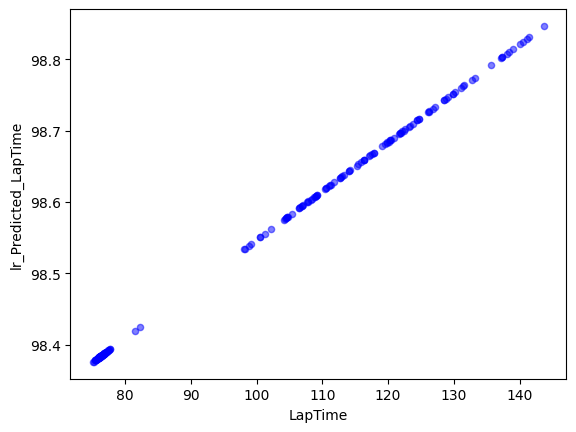

In [14]:
qlaps.plot.scatter(x="LapTime", y="lr_Predicted_LapTime", alpha=0.5, color="blue")

In [15]:
race_df = qlaps[["Driver", "lr_Predicted_LapTime"]].copy()
race_df = race_df.drop_duplicates(subset="Driver", keep='first')

In [16]:
print("The Winner of the Australian GP 2025 is: \n")
print(race_df[["Driver", "lr_Predicted_LapTime"]].head(1).to_string(index=False))

The Winner of the Australian GP 2025 is: 

Driver  lr_Predicted_LapTime
   NOR              98.37556


In [17]:
print("The Top 10 of the Australian GP 2025 are: \n")
print(race_df[["Driver", "lr_Predicted_LapTime"]].head(10).to_string(index=False))

The Top 10 of the Australian GP 2025 are: 

Driver  lr_Predicted_LapTime
   NOR             98.375560
   PIA             98.376137
   VER             98.378205
   RUS             98.378652
   TSU             98.379504
   ALB             98.379964
   LEC             98.380088
   HAM             98.381215
   SAI             98.381297
   GAS             98.381634


In [18]:
print("The Mean Absolute Error of the model is: \n")
print(mean_absolute_error(y_test, model.predict(X_test)))

The Mean Absolute Error of the model is: 

20.588343582695654


## Let's build a more complex model

In [19]:
gb = GradientBoostingRegressor(random_state=seed, learning_rate=0.1)
gb.fit(X_train, y_train)

c:\Users\paulw\OneDrive\Desktop\GitHub\005_Formula_One\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=1042)

In [20]:
predicted_lap_times = gb.predict(qlaps[["LapTime"]].values.reshape(-1, 1))
qlaps['gb_Predicted_LapTime'] = predicted_lap_times

In [21]:
qlaps.head()

,Driver,LapTime,lr_Predicted_LapTime,gb_Predicted_LapTime
0,NOR,75.096,98.375560,99.206618
1,PIA,75.180,98.376137,99.206618
2,NOR,75.415,98.377752,99.206618
3,PIA,75.468,98.378116,99.206618
4,VER,75.481,98.378205,99.206618


<Axes: xlabel='LapTime', ylabel='gb_Predicted_LapTime'>

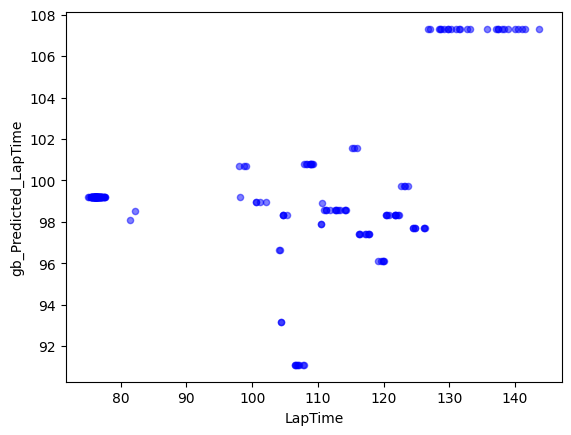

In [22]:
qlaps.plot.scatter(x="LapTime", y="gb_Predicted_LapTime", alpha=0.5, color="blue")

In [34]:
gb_data = qlaps[["Driver", "gb_Predicted_LapTime"]].copy()
gb_data = gb_data.sort_values("gb_Predicted_LapTime", ascending=True).reset_index(drop=True)
gb_data = gb_data.drop_duplicates(subset="Driver", keep='first')

print("The Winner of the Australian GP 2025 is: \n")
print(gb_data[["Driver", "gb_Predicted_LapTime"]].head(1).to_string(index=False))

The Winner of the Australian GP 2025 is: 

Driver  gb_Predicted_LapTime
   PIA             91.088192


In [36]:
print("The Top 10 of the Australian GP 2025 are: \n")
gb_data[["Driver", "gb_Predicted_LapTime"]].head(10)

The Top 10 of the Australian GP 2025 are: 



,Driver,gb_Predicted_LapTime
0,PIA,91.088192
1,HAM,91.088192
2,LEC,91.088192
3,DOO,91.088192
5,STR,91.088192
6,ANT,91.088192
7,GAS,91.088192
8,ALB,93.142254
10,VER,96.093978
11,BOR,96.093978


In [37]:
print("The Mean Absolute Error of the model is: \n")
print(mean_absolute_error(y_test, model.predict(X_test)))

The Mean Absolute Error of the model is: 

20.588343582695654


### Key Points
1. The Linear Model was actually the best (Lando Norris won the race, and Max Verstappen was second), however the MAE is very large.

2. We need more informative features, and a way to take into account rookies